In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-11-20 11:16:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-20 11:16:19 (90.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [7]:
# Walk through each directory
dataset = "/content/drive/MyDrive/train"
walk_through_dir(dataset);

There are 20 directories and 0 images in '/content/drive/MyDrive/train'.
There are 0 directories and 133 images in '/content/drive/MyDrive/train/ALBATROSS'.
There are 0 directories and 160 images in '/content/drive/MyDrive/train/STEAMER DUCK'.
There are 0 directories and 141 images in '/content/drive/MyDrive/train/MYNA'.
There are 0 directories and 150 images in '/content/drive/MyDrive/train/INDIAN VULTURE'.
There are 0 directories and 183 images in '/content/drive/MyDrive/train/INDIAN ROLLER'.
There are 0 directories and 167 images in '/content/drive/MyDrive/train/RED FODY'.
There are 0 directories and 163 images in '/content/drive/MyDrive/train/CROW'.
There are 0 directories and 154 images in '/content/drive/MyDrive/train/MOURNING DOVE'.
There are 0 directories and 131 images in '/content/drive/MyDrive/train/INDIAN BUSTARD'.
There are 0 directories and 154 images in '/content/drive/MyDrive/train/PHILIPPINE EAGLE'.
There are 0 directories and 156 images in '/content/drive/MyDrive/trai

In [8]:
image_dir = Path(dataset)# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.p.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
filepaths

0          /content/drive/MyDrive/train/ALBATROSS/036.jpg
1          /content/drive/MyDrive/train/ALBATROSS/030.jpg
2          /content/drive/MyDrive/train/ALBATROSS/038.jpg
3          /content/drive/MyDrive/train/ALBATROSS/008.jpg
4          /content/drive/MyDrive/train/ALBATROSS/026.jpg
                              ...                        
3109    /content/drive/MyDrive/train/RAINBOW LORIKEET/...
3110    /content/drive/MyDrive/train/RAINBOW LORIKEET/...
3111    /content/drive/MyDrive/train/RAINBOW LORIKEET/...
3112    /content/drive/MyDrive/train/RAINBOW LORIKEET/...
3113    /content/drive/MyDrive/train/RAINBOW LORIKEET/...
Name: Filepath, Length: 3114, dtype: object

In [10]:
labels

0              ALBATROSS
1              ALBATROSS
2              ALBATROSS
3              ALBATROSS
4              ALBATROSS
              ...       
3109    RAINBOW LORIKEET
3110    RAINBOW LORIKEET
3111    RAINBOW LORIKEET
3112    RAINBOW LORIKEET
3113    RAINBOW LORIKEET
Name: Label, Length: 3114, dtype: object

In [11]:
filepaths.head(1)

0    /content/drive/MyDrive/train/ALBATROSS/036.jpg
Name: Filepath, dtype: object

In [12]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/train/ALBATROSS/036.jpg,ALBATROSS
1,/content/drive/MyDrive/train/ALBATROSS/030.jpg,ALBATROSS
2,/content/drive/MyDrive/train/ALBATROSS/038.jpg,ALBATROSS
3,/content/drive/MyDrive/train/ALBATROSS/008.jpg,ALBATROSS
4,/content/drive/MyDrive/train/ALBATROSS/026.jpg,ALBATROSS
...,...,...
3109,/content/drive/MyDrive/train/RAINBOW LORIKEET/...,RAINBOW LORIKEET
3110,/content/drive/MyDrive/train/RAINBOW LORIKEET/...,RAINBOW LORIKEET
3111,/content/drive/MyDrive/train/RAINBOW LORIKEET/...,RAINBOW LORIKEET
3112,/content/drive/MyDrive/train/RAINBOW LORIKEET/...,RAINBOW LORIKEET


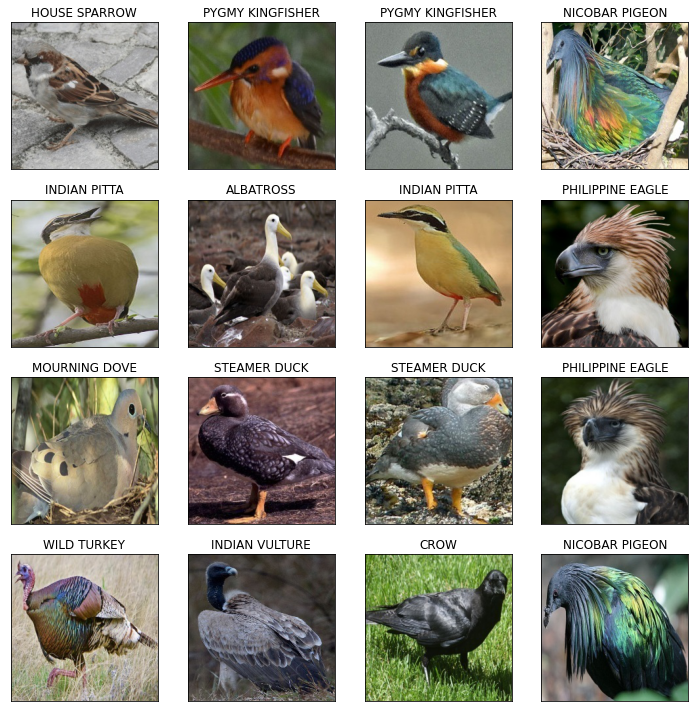

In [13]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()

In [14]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [15]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


In [16]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 1993 validated image filenames belonging to 20 classes.
Found 498 validated image filenames belonging to 20 classes.
Found 623 validated image filenames belonging to 20 classes.


In [17]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [19]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [20]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [21]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)



outputs = Dense(20, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "bird_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bird_classification/20221120-111808
Epoch 1/10
63/63 [==============================] - 956s 15s/step - loss: 2.5679 - accuracy: 0.3081 - val_loss: 1.7930 - val_accuracy: 0.7831
Epoch 2/10
63/63 [==============================] - 8s 135ms/step - loss: 1.3228 - accuracy: 0.7772 - val_loss: 0.6438 - val_accuracy: 0.9538
Epoch 3/10
63/63 [==============================] - 9s 138ms/step - loss: 0.5895 - accuracy: 0.8996 - val_loss: 0.2817 - val_accuracy: 0.9779
Epoch 4/10
63/63 [==============================] - 9s 138ms/step - loss: 0.3265 - accuracy: 0.9453 - val_loss: 0.1712 - val_accuracy: 0.9839
Epoch 5/10
63/63 [==============================] - 9s 137ms/step - loss: 0.2127 - accuracy: 0.9659 - val_loss: 0.1187 - val_accuracy: 0.9859
Epoch 6/10
63/63 [==============================] - 8s 134ms/step - loss: 0.1613 - accuracy: 0.9689 - val_loss: 0.0989 - val_accuracy: 0.9859
Epoch 7/10
63/63 [==============================] - 9s 137ms/step

In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06489
Test Accuracy: 98.23%


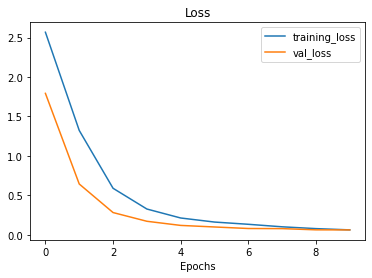

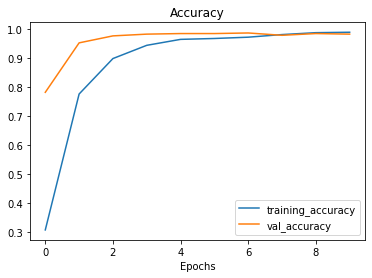

In [23]:
plot_loss_curves(history)

In [24]:
test_images[0]

(array([[[[-0.52156866, -0.5294118 , -0.67058825],
          [-0.5372549 , -0.54509807, -0.6862745 ],
          [-0.5372549 , -0.5529412 , -0.67058825],
          ...,
          [-0.372549  , -0.35686272, -0.52156866],
          [-0.3960784 , -0.38039213, -0.54509807],
          [-0.34117645, -0.3490196 , -0.5058824 ]],
 
         [[-0.5058824 , -0.5137255 , -0.654902  ],
          [-0.52156866, -0.5294118 , -0.67058825],
          [-0.52156866, -0.5372549 , -0.654902  ],
          ...,
          [-0.38039213, -0.36470586, -0.5529412 ],
          [-0.38823527, -0.38823527, -0.5764706 ],
          [-0.38039213, -0.38823527, -0.5529412 ]],
 
         [[-0.4980392 , -0.5058824 , -0.64705884],
          [-0.5137255 , -0.52156866, -0.6627451 ],
          [-0.5137255 , -0.5294118 , -0.64705884],
          ...,
          [-0.372549  , -0.372549  , -0.5921569 ],
          [-0.40392154, -0.40392154, -0.62352943],
          [-0.40392154, -0.41176468, -0.6313726 ]],
 
         ...,
 
         [[-

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

20/20 [==============================] - 3s 103ms/step
The first 5 predictions: ['PHILIPPINE EAGLE', 'CROW', 'INDIAN VULTURE', 'PYGMY KINGFISHER', 'PHILIPPINE EAGLE']


In [26]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [27]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                          precision    recall  f1-score   support

               ALBATROSS       1.00      1.00      1.00        30
                    CROW       0.96      1.00      0.98        26
           HOUSE SPARROW       0.96      0.92      0.94        26
          INDIAN BUSTARD       1.00      1.00      1.00        28
            INDIAN PITTA       1.00      0.92      0.96        36
           INDIAN ROLLER       0.97      1.00      0.99        35
          INDIAN VULTURE       0.97      0.97      0.97        37
           MOURNING DOVE       0.97      0.94      0.96        34
                    MYNA       1.00      1.00      1.00        33
          NICOBAR PIGEON       1.00      0.96      0.98        26
                 OSTRICH       0.97      1.00      0.99        35
                 PEACOCK       1.00      1.00      1.00        32
        PHILIPPINE EAGLE       0.97      1.00      0.98        30
        PYGMY KINGFISHER       0.97      1.00      0.99        39
        R

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [29]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
ALBATROSS,1.000000,1.000000,1.000000,30.000000
CROW,0.962963,1.000000,0.981132,26.000000
HOUSE SPARROW,0.960000,0.923077,0.941176,26.000000
INDIAN BUSTARD,1.000000,1.000000,1.000000,28.000000
INDIAN PITTA,1.000000,0.916667,0.956522,36.000000
INDIAN ROLLER,0.972222,1.000000,0.985915,35.000000
INDIAN VULTURE,0.972973,0.972973,0.972973,37.000000
MOURNING DOVE,0.969697,0.941176,0.955224,34.000000
MYNA,1.000000,1.000000,1.000000,33.000000
NICOBAR PIGEON,1.000000,0.961538,0.980392,26.000000


In [30]:
# Python Program illustrating
# working of ndarray.flat()
 
import numpy as geek
 
# Working on 1D iteration of 2D array
array = geek.arange(15).reshape(3, 5)
print("2D array : \n",array )
 
# Using flat() : 1D iterator over range
print("\nUsing Array : ", array.flat[2:6])
 
# Using flat() to Print 1D represented array
print("\n1D representation of array : \n ->", array.flat[0:15])

2D array : 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]

Using Array :  [2 3 4 5]

1D representation of array : 
 -> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [33]:
model.save("/content/drive/MyDrive/model.h5")

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [36]:
from keras.models import load_model
model = load_model('model.h5')

OSError: ignored